## **João Lucas de Moraes Barros Cadorniga**

# Prova 2 - NLP - 2025s1

INSTRUÇÕES: Resolva esta prova. Após, transcreva as partes dissertativas das respostas para o Blackboard (CTRL-C / CTRL-V) nos espaços indicados. Por fim, anexe seu notebook como material complementar da Questão 2.

## Rubrica geral da prova

Níveis de aprendizado

* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

## Problema

É relativamente comum usarmos embeddings gerados pelo BERT para classificar frases. Em geral, o código para gerar embeddings com BERT se parece com:

    from transformers import BertTokenizer, BertModel
    from tqdm import tqdm
    import numpy as np
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    def get_embeddings(text, model, tokenizer):
        # Tokenize the input text
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[0, 0, :]
        return cls_embedding

    embeddings = []
    for i in tqdm(range(len(X))):
        e = get_embeddings(X.iloc[i], model, tokenizer)
        embeddings.append(e.detach().numpy())
    embeddings = np.array(embeddings)
    np.save('bert_embeddings.npy', embeddings)

De acordo com o [artigo do BERT](https://arxiv.org/abs/1810.04805), os embeddings foram treinados, usando um token por palavra, em diversos textos em inglês:

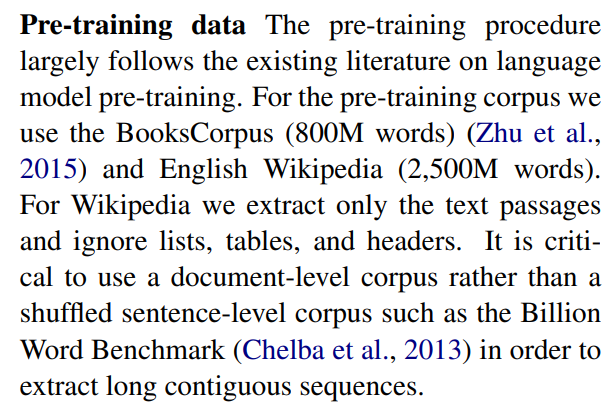

Porém, em lugares que não temos a língua inglesa como língua padrão, gostaríamos de realizar tarefas de classificação em línguas nativas.

Neste trabalho, vamos trabalhar com a classificação de mensagens no twitter sobre o Ibovespa. A ideia de fazer essa classificação é que o Twitter poderia ser uma representação do sentimento geral do mercado (*bullish* ou *bearish* markets). O dataset para isso é o seguinte:

In [1]:
import kagglehub
from pathlib import Path
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("jvbeltra/sentiment-analysis-pt-br-stock-market-tweets")
path = Path(path)
df = pd.read_csv(path / "analise_sentimentos_ibovespa_twitter.csv")
df.head()

100%|██████████| 92.7k/92.7k [00:00<00:00, 407kB/s]

Extracting files...


,post_id,text,created_at,finbertptbr_prediction,gpt_prediction,real_sentiment
0,1818246570069934451,"a partir desse cálculo, para cada empresa do i...",2024-07-30T08:25:38.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
1,1818251106570395982,ibovespa reage às entrelinhas do relatório de ...,2024-07-30T08:43:39.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
2,1818257465793765640,ibovespa em queda de olho na reunião do copom,2024-07-30T09:08:56.000000Z,NEGATIVE,NEGATIVE,NEGATIVE
3,1818262436144669087,esquenta dos mercados \nbom dia!\no ibovespa a...,2024-07-30T09:28:41.000000Z,POSITIVE,NEUTRAL,NEUTRAL
4,1818262819063660642,ibovespa futuro cai na expectativa pelo 1º dia...,2024-07-30T09:30:12.000000Z,NEGATIVE,NEGATIVE,NEGATIVE


Como podemos ver, a tarefa é relacionar o conteúdo da coluna "text" ao rótulo colocado em "real_sentiment". Este dataset em especial já traz predições realizadas por outros modelos (finBertPt e GPT 3.5), que foram usadas em trabalhos anteriores. Ignore essas informações pois não vamos usá-las.

Para extrair embeddings de todos os textos do dataset, podemos usar o seguinte laço:

In [8]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
def get_embeddings(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[0, 0, :]
    return cls_embedding

embeddings = []
for i in tqdm(range(len(df))):
    e = get_embeddings(df.iloc[i]['text'], model, tokenizer)
    embeddings.append(e.detach().numpy())
embeddings = np.array(embeddings)
np.save('bert_embeddings.npy', embeddings)

100%|██████████| 1290/1290 [03:13<00:00,  6.66it/s]


Porém, BERT foi treinado em inglês, e, portanto, talvez haja problemas com o vocabulário em português. Para evitar isso é possível usar a versão multilingual de BERT, que foi treinada em dumps da Wikipedia em várias línguas:

In [14]:
tokenizer_pt = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model_pt = BertModel.from_pretrained("bert-base-multilingual-uncased")
embeddings = []
for i in tqdm(range(len(df))):
    e = get_embeddings(df.iloc[i]['text'], model_pt, tokenizer_pt)
    embeddings.append(e.detach().numpy())
embeddings = np.array(embeddings)
np.save('bert_pt_embeddings.npy', embeddings)

100%|██████████| 1290/1290 [03:02<00:00,  7.05it/s]


Por fim, temos sempre nossa hipótese nula: a de que um sistema com Bag of Words funciona bem o suficiente para nossa tarefa:

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['real_sentiment'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.19      0.30        53
     NEUTRAL       0.61      0.74      0.67        98
    POSITIVE       0.71      0.83      0.76       107

    accuracy                           0.67       258
   macro avg       0.70      0.59      0.58       258
weighted avg       0.68      0.67      0.63       258



## Perguntas

### Exercício 1

Por que faz sentido dizer que o BERT multilingue deveria ser uma alternativa melhor que o BERT original para esta tarefa de classificação? Articule sua argumentação tendo em vista a rubrica:


* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

---

Um modelo de embeddings como o BERT é um modelo que foi treinado para transformar os tokens dos documentos em vetores de dimensão $d$, e então sumarizá-los para encontrar um vetor que represente o documento por completo. Por ser alimentado com textos da Wikipedia durante seu treinamento, o modelo constrói um vocabulário o qual associa cada token (no caso do BERT, cada palavra) a um vetor. 

A vantagem de um modelo como esse é que ele considera a posição das palavras no contexto do documento, o que normalmente é associado ao modelo "considerar o significado do texto", o que causa que documentos que possuam relações parecidas apareçam próximos no espaço euclidiano. Assim, é possível tentar encontrar uma "reta" que separe esses vetores multi-dimensionais nas suas categorias corretas, usando, então, os embbedings para um problema de classificação de documentos.

No entanto, isso também inclui uma limitação. Ao utilizar um modelo de embeddings pré-treinado, estamos limitados a esse treinamento, aos contextos e às palavras que o modelo aprendeu. Isto é, em um caso como o apresentado, no qual o dataset é composto de textos em português e o BERT original foi treinado apenas com textos em inglês $¹$, os tokens que entrarão no modelo de embeddings serão desconhecidos, o que tira sua capacidade de devolver vetores que considerem o contexto de cada palavra. O problema é semelhante ao que acontece com um humano: se tentarmos compreendeer e resumir um texto em um idioma que não conhecemos ou conhecemos muito pouco, não conseguiremos gerar um resumo com um resultado tão bom quanto com um idioma que conhecemos.

Portanto, faz sentido dizer que o BERT multilingue seja uma alternativa melhor, pois textos em português também foram incluidos no treinamento. Vale ressaltar que isso também não faz o modelo tão ideal quanto um BERT que fosse treinado apenas com textos em português brasileiro, o que aumentaria o seu conhecimento do vocabulário do idioma e das estruturas de textos em PT-BR, mas faz sentido esperar que seja superior ao BERT que não conhece os tokens do texto.

----

$¹$ **BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding**, *p. 5*, Devlin J et al., 2019. Available at: https://doi.org/10.48550/arXiv.1810.04805

### Exercício 2

Compare o classificador que usa BERT original com aquele que usa BERT multilingual. De acordo com os resultados de classificação, e com a visualização de embeddings usando TSNE (se quiser, use também PCA), discuta se os argumentos discutidos no exercício 1 se refletiram, de fato, em um aumento de desempenho.

* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

---

Analisando tanto a acurácia dos modelos quanto os gráficos dos embbedings, é possível ver que o resultado de utilizar o BERT multilingual foi fora do esperado e discutido anteriormente. 

* Métricas: o modelo inclusive apresentou pequena piora em algumas métricas, como o f-1 score de quase todas as classes, e uma acurácia geral de 0.6, igual ao BERT convencional. 

* Gráficos do T-SNE: ambos os embbedings não conseguiram separar visualmente as classes dos tweets.

No entanto, tal resultado, apesar de contrário, não anula os principais argumentos apresentados anteriormente para esperar uma melhora. O BERT multilingual possui a vantagem de ser treinado com textos em PT-BR, enquanto o BERT conhece apenas o inglês. Mas, também como citado na última questão, o BERT multilingual apresenta uma limitação clara, que foi muito confirmada por esses resultados abaixo: a presença de muitas línguas também limita a capacidade de aprendizado do modelo. Como pode ser visto na [documentação](https://github.com/google-research/bert/blob/master/multilingual.md#list-of-languages) do BERT multilingual, ele foi treinado com textos da Wikipedia das *100 linguas mais comuns* do mundo. Isso causa dois problemas principais, que podem estar relacionados ao resultado do experimento:

1. *Algumns idiomas tem pouca representatividade na Wikipedia*. 

Apesar de que a documentação descreve estratégias para balancear os idiomas no treinamento, não é possível fugir do fato que existem muitos mais textos em inglês na Wikipedia do que outros idiomas.

2. *Quanto mais idiomas, mais eles "brigam" por espaço*.

Como um modelo de embbedings, por mais denso que seja, possui limitações do seu tamanho. Quanto mais idiomas, mais o modelo precisa aprender, e pode acabar não aprendendo com tanta qualidade como um modelo treinado apenas em português, que seria "focado" em entender mais palavras e mais relações dos tokens na língua.

Além disso, isso não significa necessariamente que, se retirados os outros idiomas do treinamento, o resultado seria extremamente positivo. É possível que os jargões, as expressões e as estruturas do dataset de tweets sobre o Ibovespa tenha grandes diferenças dos textos da Wikipedia, o que também pode dificultar os embbedings para essa classificação.

Portanto, apesar de que fazia sentido esperar uma melhora no modelo de classificação, também faz sentido entender que essas possíveis causas de problemas do modelo parecem suficientes para causar que o BERT multilingual não tenha melhora e ainda esteja abaixo do baseline (Bag of Words).

Neste caso, o BoW apresentou vantagem pois, uma de suas limitações acabou o ajudando: ele apenas considerar apenas as frequências de cada palavra do vocabulário no documento, independente de seu idioma, posição e contexto na frase.

Por fim, podemos concluir que os argumentos da primeira questão não refletiram no desempenho, mas, isso não significou que eram inválidos, mas trouxe à tona outras limitações nos modelos utilizados para essa tarefa.

In [8]:
embeddings = np.load('bert_embeddings.npy')
embeddings_pt = np.load('bert_pt_embeddings.npy')

### BERT ORIGINIAL

In [5]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['real_sentiment'], test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.35      0.32      0.34        53
     NEUTRAL       0.61      0.60      0.61        98
    POSITIVE       0.69      0.73      0.71       107

    accuracy                           0.60       258
   macro avg       0.55      0.55      0.55       258
weighted avg       0.59      0.60      0.59       258



### BERT MULTILINGUAL

In [6]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_pt, df['real_sentiment'], test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.41      0.21      0.28        53
     NEUTRAL       0.59      0.61      0.60        98
    POSITIVE       0.65      0.79      0.71       107

    accuracy                           0.60       258
   macro avg       0.55      0.53      0.53       258
weighted avg       0.58      0.60      0.58       258



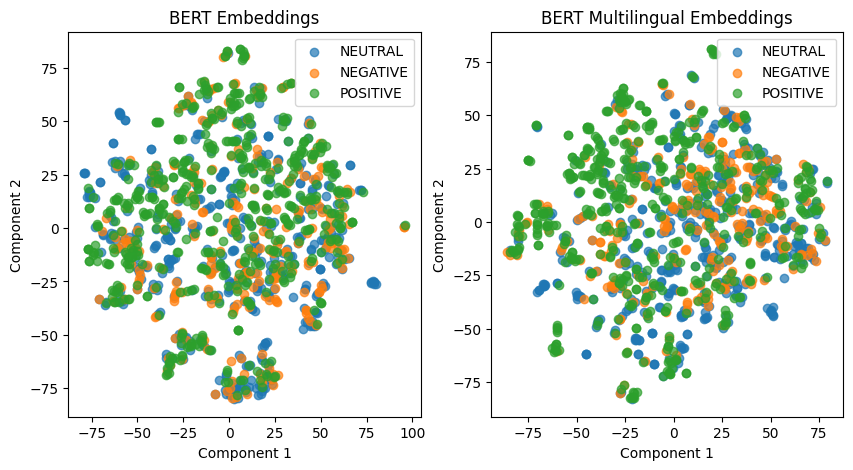

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt

# Perform PCA on the embeddings
embeddings = np.load('bert_embeddings.npy')
embeddings_pt = np.load('bert_pt_embeddings.npy')
pca = TSNE(n_components=2, perplexity=5)
embeddings_pca = pca.fit_transform(embeddings)
pca_pt = TSNE(n_components=2, perplexity=5)
embeddings_pca_pt = pca_pt.fit_transform(embeddings_pt)

# Create a scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for sentiment in df['real_sentiment'].unique():
    indices = df['real_sentiment'] == sentiment
    plt.scatter(embeddings_pca[indices, 0], embeddings_pca[indices, 1], label=sentiment, alpha=0.7)

plt.title("BERT Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()


plt.subplot(1, 2, 2)
for sentiment in df['real_sentiment'].unique():
    indices = df['real_sentiment'] == sentiment
    plt.scatter(embeddings_pca_pt[indices, 0], embeddings_pca_pt[indices, 1], label=sentiment, alpha=0.7)

plt.title("BERT Multilingual Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()
